# Top tagging model with ResNet-50 

This is a training script about using top tagging data to train a ResNet-50 Neuron Network. <br>
The training is base on Keras and using tensorflow backend to run.

## Import necessary package and do gpu test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import hdf5plugin 
import h5py 
import os
from keras.utils import np_utils
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPU


## Input data with H5py package
Input data size: 1 channel image with shape 224x224. <br>
Input label size: 1 or 0 with onehot encoding. <br>
\# of input data(train(with val), test): 30000,6000

In [2]:
train_img_pt = []
test_img_pt = []
val_img_pt = []
train_label_ = []
test_label_ = []
val_label_ = []

prefix = "/home/david/ResNet-50-Keras/data/"
train_file = "train/train_file_"
test_file = "test/test_file_"
val_file = "val/val_file_"
file_type = ".h5"
path = []
filename = ''
for i in range(5,7):
    seq =  (train_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f:
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(len(pt_)):
            train_img_pt.append(pt_[a])
        for b in range(len(label_)):
            train_label_.append(label_[b])

for i in range(0,1):
    seq =  (test_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,2000):
            test_img_pt.append(pt_[a])
        for b in range(0,2000):
            test_label_.append(label_[b])

            
for i in range(0,1):
    seq =  (val_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,2000):
            val_img_pt.append(pt_[a])
        for b in range(0,2000):
            val_label_.append(label_[b])


In [3]:
"""
qq = 0
tt = 0
c1 = 0
c2 = 0
for i in range(len(train_img_pt)): 
    if (np.argmax(train_label_[i]) == 1):
        qq += train_img_pt[i]/train_img_pt[i].max()
        c1 += 1
    else :
        tt += train_img_pt[i]/train_img_pt[i].max()
        c2 +=1
        
color_map = plt.imshow(qq)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.xlabel(r'$i\eta$')
plt.ylabel(r'$i\phi$')
plt.title('QCD, about 15K events')
plt.savefig("qcd.png")
print(c1,c2)
"""

'\nqq = 0\ntt = 0\nc1 = 0\nc2 = 0\nfor i in range(len(train_img_pt)): \n    if (np.argmax(train_label_[i]) == 1):\n        qq += train_img_pt[i]/train_img_pt[i].max()\n        c1 += 1\n    else :\n        tt += train_img_pt[i]/train_img_pt[i].max()\n        c2 +=1\n        \ncolor_map = plt.imshow(qq)\ncolor_map.set_cmap("Blues_r")\nplt.colorbar()\nplt.xlabel(r\'$i\\eta$\')\nplt.ylabel(r\'$i\\phi$\')\nplt.title(\'QCD, about 15K events\')\nplt.savefig("qcd.png")\nprint(c1,c2)\n'

In [4]:
"""
color_map = plt.imshow(tt)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.xlabel(r'$i\eta$')
plt.ylabel(r'$i\phi$')
plt.title('Top, about 15K events')
plt.savefig("top.png")
"""

'\ncolor_map = plt.imshow(tt)\ncolor_map.set_cmap("Blues_r")\nplt.colorbar()\nplt.xlabel(r\'$i\\eta$\')\nplt.ylabel(r\'$i\\phi$\')\nplt.title(\'Top, about 15K events\')\nplt.savefig("top.png")\n'

## Define function to do normalize and duplicate image to 3 channel. <br>
Image will be normalize to 0~255 and duplicate into 3 channel.

In [5]:
def normalize_and_rgb(img, label):  
    output = np.stack([np.asanyarray(img)/ np.asanyarray(img).max(), np.asanyarray(img)/ np.asanyarray(img).max(), np.asanyarray(img)/ np.asanyarray(img).max()],axis=-1)
    return output, np.asanyarray(label)
train_img, train_label = normalize_and_rgb(train_img_pt, train_label_)
test_img, test_label = normalize_and_rgb(test_img_pt, test_label_)
val_img, val_label = normalize_and_rgb(val_img_pt, val_label_)

In [4]:
#print(train_img, train_label, test_img, test_label)
#train_label = np.asanyarray(train_label_)
#test_label = np.asanyarray(test_label_)
#print(train_label.shape, test_label.shape)

## Construsting a sequential 
Construst a model with Keras pre-configured ResNet-50 and one Dense layer with Softmax activation function. <br>
Using Earlystopping and custom callback function to prevent training from overfitting and collect ROC/AUC data point. 

In [12]:
import datetime

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def create_model():
    return tf.keras.models.Sequential([
    #model.load_weights=('../aws-fpga-top-tagging-notebooks/dataset_Tom/weights-floatingpoint-224x224-fixval-best/class_weights.h5')
    tf.keras.applications.ResNet50(weights=None, pooling='max',classes = 2),
    tf.keras.layers.Dense(2, activation='softmax'),
    ])

#modelcheckpoint = ModelCheckpoint('./model/ResNet-50-best.model', monitor='val_acc', save_best_only=True)
#earlystop = EarlyStopping(monitor='val_loss', patience=0, mode='min')

def train_model():
    model = create_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    logdir = os.path.join("logs","fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    train_history = model.fit(x=train_img, y=train_label, epochs=10, batch_size=64,validation_data=(val_img, val_label), callbacks=[tensorboard_callback])
    model.summary()
    return train_history, model
train_history, model = train_model()

Train on 20000 samples, validate on 2000 samples
Epoch 1/10
20000/20000 [==============================] - 116s 6ms/sample - loss: 0.4824 - accuracy: 0.8522 - val_loss: 0.8595 - val_accuracy: 0.4850
Epoch 2/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.3933 - accuracy: 0.8789 - val_loss: 1.0271 - val_accuracy: 0.4850
Epoch 3/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.3756 - accuracy: 0.8747 - val_loss: 1.1754 - val_accuracy: 0.4850
Epoch 4/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.3559 - accuracy: 0.8785 - val_loss: 1.3109 - val_accuracy: 0.4850
Epoch 5/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.3410 - accuracy: 0.8848 - val_loss: 0.9439 - val_accuracy: 0.5150
Epoch 6/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.3402 - accuracy: 0.8843 - val_loss: 1.4668 - val_accuracy: 0.4850
Epoch 7/10
20000/20000 [===========================

## Define function to visualize learning curve and prediction. <br><br>

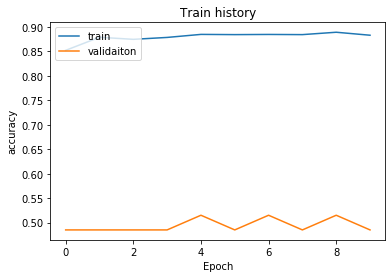

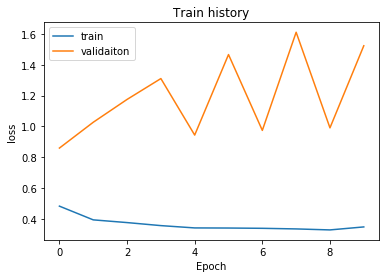

In [13]:
#Define a function to show training history
def show_train_history(train_history, train, validation,filename):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train','validaiton'],loc='upper left')
    plt.savefig(filename)
    plt.show()

def plot_images_prediction(iamges, labels, prediction, idx, num = 10):
    fig = plt.gcf()
    fig.set_size_inches(12,14)
    if num>25: num=25
    for i in range(0,num):
        ax=plt.subplot(5,5,1+i)
        ax.imshow(iamges[idx], cmap='binary')
        title = "label=" + str(np.argmax(labels[idx]))
        if len(prediction)>0 :
            title += ",prediction=" + str(np.argmax(prediction[idx]))
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.savefig(filename)
    plt.show()
    
#Show the result of training 
show_train_history(train_history,'accuracy','val_accuracy','./acc.png')
show_train_history(train_history,'loss','val_loss',filename='./loss.png')


2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Accuracy of model is 0.53
[[0.0546766 0.9453234]
 [0.0546766 0.9453234]
 [0.0546766 0.9453234]
 ...
 [0.0546766 0.9453234]
 [0.0546766 0.9453234]
 [0.0546766 0.9453234]]


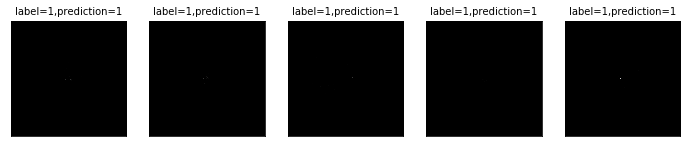

In [14]:
#Scoring the accuracy of model by test dataset.
score = model.evaluate(test_img, test_label)
print()
print("Accuracy of model is", score[1])

#Prediction 
prediction = model.predict(test_img)
print(prediction)

test_label_wo_onehot = np.zeros(len(test_label))
pred = np.zeros(len(test_label))
for i in range(len(test_label)):
    test_label_wo_onehot[i] = np.argmax(test_label[i])
    pred[i] = np.argmax(prediction[i])

plot_images_prediction(test_img,test_label, prediction,idx=1,num=5)





In [15]:
#Display confusion matrix
pd.crosstab(test_label_wo_onehot, pred, rownames=['label'], colnames=['predict'])

predict,1.0
label,
0.0,940
1.0,1060


In [16]:
#Display true value and predict value 
df = pd.DataFrame({'label':test_label_wo_onehot,'predict':pred})
df[:10]


,label,predict
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [18]:
#Find the result that true value is x but pred value is y (x != y)
df[(df.label==1)&(df.predict==0)]


,label,predict


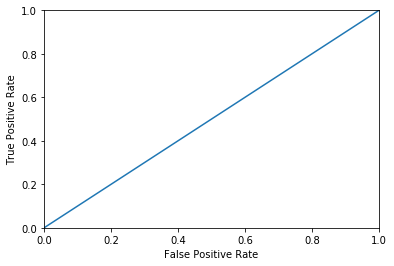

In [26]:
from sklearn.metrics import roc_curve,roc_auc_score
 
fpr , tpr , thresholds = roc_curve ( test_label_wo_onehot  , pred )

def plot_roc_curve(fpr,tpr,filename): 
    plt.plot(fpr,tpr)
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.savefig(filename)
    plt.show()    

plot_roc_curve(fpr,tpr,'./roc.png') 
auc_score = roc_auc_score(test_label_wo_onehot, pred)